In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize
from scipy.interpolate import interp1d

from datetime import datetime
import pytz

import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"
sns.set(style="darkgrid")

Welcome to JupyROOT 6.12/04


RMS dm/dz is 0.1463552789393218 ppm/mm.
Mean dm/dz is 2.4671622769447924e-20 ppm/mm.


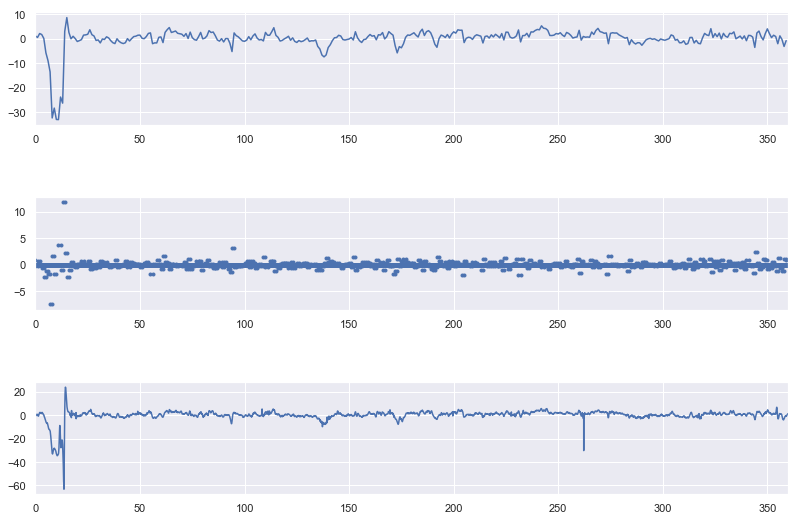

In [11]:
# Trolley azimuthal uncertainty couples to dm/dphi

# calculate dm/dphi from trolley, run 3956
# interpolate the moment vs phi to standard phi values (36,000 points)

corrected_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
corrected_df = corrected_df.sort_values(by=['tr_phi'])

trm = 'tr,m2'

new_phis = np.arange(36000)/100
old_phis = np.append(corrected_df['tr_phi'].values - 360,
                     np.append(corrected_df['tr_phi'].values,
                               corrected_df['tr_phi'].values + 360)
                    )
old_ms = np.append(corrected_df[trm].values,
                   np.append(corrected_df[trm].values,
                             corrected_df[trm].values)
                  )/61.79  # convert to ppm

new_ms = interp1d(old_phis, old_ms, kind='slinear')(new_phis)

dm_dphi = (np.roll(new_ms, -1) - np.roll(new_ms, 1))/(2*0.01)
dm_dz = dm_dphi * (1/124.13)  # deg/mm

rms_dm_dz = np.std(dm_dz)
print 'RMS dm/dz is ' + str(rms_dm_dz) + ' ppm/mm.'
print 'Mean dm/dz is ' + str(np.mean(dm_dz)) + ' ppm/mm.'

fig, axs = plt.subplots(3,1)
plt.sca(axs[0])
plt.plot(new_phis, new_ms)
axs[0].set_xlim((0,360))
# axs[0].set_ylim((750,900))

plt.sca(axs[1])
plt.plot(new_phis, dm_dz, '.')
axs[1].set_xlim((0,360))
# axs[1].set_ylim((48000,56000))

plt.sca(axs[2])
plt.plot(old_phis, old_ms)
axs[2].set_xlim((0,360))
# axs[2].set_ylim((750,900))

fig.tight_layout()
fig.set_size_inches(12,8)

In [3]:
# calculate rms uncertainty for fixed probes after removing drift

def quad_fit(x, a, b, c):
    return a + b*x + c*x**2/2

fp_run = trfp.FixedProbeRun(3960)

Reading event 4360/4370 99.77%  
loop done: 100%                                    
Finished calculating all moments for 3640 events.                                                     


In [4]:
_, raw_times, raw_freqs = fp_run.fp_run.getBasics()
raw_times = raw_times/1.0e9

Reading event 4360/4370 99.77%     
loop done: 100%                                    


In [5]:
rms_uncs = np.zeros(378)

num_points = 100
points_offset = 1000

start_time = np.min(raw_times[0,:])
times = raw_times[points_offset:points_offset+num_points, :] - start_time
freqs = raw_freqs[points_offset:points_offset+num_points, :]



for probe in np.arange(378):
    coeffs, _ = scipy.optimize.curve_fit(quad_fit, times[:,probe], freqs[:,probe])
    drift = quad_fit(times[:, probe], coeffs[0], coeffs[1], coeffs[2])
    resids = freqs[:,probe] - drift
    rms_uncs[probe] = np.std(resids)
    print '\rProbe ' + str(probe) + '.',

Probe 31.

/home/aetb/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Probe 377.   


In [15]:
var_uncs = rms_uncs**2

moment_uncs = np.empty((72,6))
moment_uncs[:] = np.nan

for st in np.arange(72):
    var_temp = var_uncs[trfp.STATION_PROBE_ID[st]]
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        if num_probes == 6:
            moment_uncs[st, m] = np.dot(np.abs(trfp.THETA_FP_6[m]), var_temp)
        else:
            moment_uncs[st, m] = np.dot(np.abs(trfp.THETA_FP_4[m]), var_temp)
moment_uncs = np.sqrt(moment_uncs)

print np.std(moment_uncs[:,0]/61.79)
print np.mean(moment_uncs[:,0]/61.79)
print np.round(moment_uncs/61.79,3)

0.21806703557330295
0.06853251211350231
[[0.022 0.031 0.017 0.024 0.062 0.047]
 [1.478 2.122 1.13  1.622 3.997 3.056]
 [0.068 0.101 0.052 0.078 0.179 0.137]
 [0.536 0.757 0.41  0.578 1.471 1.125]
 [0.027 0.04  0.021 0.03  0.073 0.056]
 [1.101 1.55  0.842 1.185 3.028 2.315]
 [0.013 0.016 0.01  0.012 0.038 0.029]
 [0.014 0.029 0.013 0.022   nan   nan]
 [0.029 0.042 0.022 0.032 0.078 0.06 ]
 [0.018 0.03  0.013 0.023   nan   nan]
 [0.017 0.021 0.013 0.016 0.049 0.038]
 [0.017 0.031 0.013 0.023   nan   nan]
 [0.017 0.023 0.013 0.017 0.047 0.036]
 [0.019 0.029 0.013 0.022   nan   nan]
 [0.027 0.039 0.021 0.03  0.074 0.056]
 [0.127 0.183 0.081 0.14    nan   nan]
 [0.019 0.026 0.015 0.02  0.056 0.042]
 [0.014 0.024 0.01  0.018   nan   nan]
 [0.025 0.036 0.019 0.027 0.067 0.051]
 [0.035 0.049 0.026 0.038 0.094 0.072]
 [0.022 0.027 0.017 0.02  0.065 0.05 ]
 [0.077 0.035 0.059 0.027 0.275 0.21 ]
 [0.014 0.019 0.011 0.014 0.04  0.03 ]
 [0.043 0.062 0.033 0.047 0.114 0.087]
 [0.012 0.016 0.009 0.01

0.01382497165316501
[0.03499468 0.00924226 0.00936015 0.41872223 0.68733971 1.81704616
 0.10032868 0.0168356  0.01098314 0.25110678 0.08890708 0.42722773
 0.05114929 0.01205507 0.0137782  0.64533605 0.83162805 2.17199749
 0.01423205 0.01871189 0.03192925 2.87860858 0.78876056 0.49819484
 0.13029635 0.01299757 0.01658708 1.13171638 0.43637304 0.01805106
 0.03490267 0.01075454 0.01281343 0.79809886 0.42558105 0.79680502
 0.01252077 0.01213038 0.01056036 0.01266991 0.01186905 0.01247006
 0.01696929 0.06447876 0.01585963 0.02002196 0.01799156 0.01569115
 0.01346818 0.01677141 0.02063515 0.01691187 0.01304714 0.01002755
 0.01555909 0.0246397  0.01565721 0.01014473 0.01006307 0.01925461
 0.0133414  0.01883186 0.01575441 0.0178275  0.01683049 0.01581734
 0.01001467 0.01368055 0.01969183 0.02195252 0.01904437 0.0506565
 0.01550072 0.02191474 0.17787544 0.11203766 0.02163591 0.01631876
 0.02850927 0.0148012  0.01424684 0.02604784 0.01047078 0.01495876
 0.01426582 0.01010147 0.02416574 0.0128138

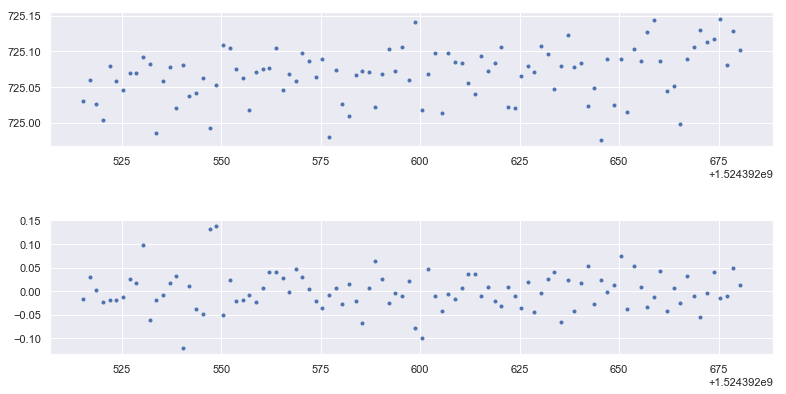

In [12]:
print rms_uncs[137]/61.79

print rms_uncs/61.79


fig, axs = plt.subplots(2,1)
plt.sca(axs[0])
plt.plot(times[:,0], freqs[:,0]/61.79, '.')
plt.sca(axs[1])
plt.plot(times[:,0], resids/61.79, '.')
fig.tight_layout()
fig.set_size_inches(12,6)